# Data assimilation Demo
model : 1-dimensional Toy model (Lorenz 1996)
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$
DA method : Kalman Filter, 3DVar, Ensemble Kalman Filter (ETKF, PO, EnSRF, LETKF), Maximum Likelihoon Ensemble Filter

In [1]:
# module import
import sys
import os
import logging
from logging.config import fileConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

logging.config.fileConfig("logging_config.ini")
logger = logging.getLogger(__name__)

In [2]:
# model parameter
model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)
logging.info("nx={} F={} dt={:7.3e}".format(nx, F, dt))

# forecast model forward operator
step = L96(nx, dt, F)

2020-11-26 14:23:15,665 root INFO nx=40 F=8.0 dt=8.333e-03


In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameter (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
lloc = True # localization switch (True=Apply, False=Not apply)
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [10]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# assimilation method
from analysis.mlef import Mlef
analysis = Mlef(pt, obs, 1.1, model)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, 1.1, 4.0, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, 1.1, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2020-11-26 14:25:45,641 anl INFO model : l96
2020-11-26 14:25:45,642 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1


In [11]:
# parameter describe
logging.info("nmem={} t0f={}".format(nmem, t0f))
logging.info("nt={} na={}".format(nt, na))
logging.info("htype={} sigma={} ftype={}".format\
    (htype, sigma[op], ftype[pt]))
logging.info("inflation={} localization={} TLM={}".format(linf,lloc,ltlm))
logging.info("Assimilation window size = {}".format(a_window))

2020-11-26 14:25:53,985 root INFO nmem=20 t0f=[500, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512, 520, 528, 536, 544, 552, 560, 568, 576]
2020-11-26 14:25:53,985 root INFO nt=6 na=100
2020-11-26 14:25:53,986 root INFO htype={'operator': 'linear', 'perturbation': 'mlef'} sigma=1.0 ftype=ensemble
2020-11-26 14:25:53,987 root INFO inflation=True localization=True TLM=True
2020-11-26 14:25:53,987 root INFO Assimilation window size = 1


In [12]:
# functions load
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

In [13]:
logging.info("==initialize==")
xt, yobs = func.get_true_and_obs()
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
    
a_time = range(0, na, a_window)
logging.info("a_time={}".format([time for time in a_time]))
e = np.zeros(na)
chi = np.zeros(na)
ncycle = 1
for i in a_time:
    y = yobs[i:i+a_window]
    logging.info("cycle{} analysis".format(ncycle))
    if a_window > 1:
        u, pa, chi2 = analysis(u, pf, y, \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)
    else:
        u, pa, chi2 = analysis(u, pf, y[0], \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)

    xa[i] = u
    sqrtpa[i] = pa
    chi[i] = chi2
    if i < na-1:
        if a_window > 1:
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    if a_window > 1:
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft=="deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    ncycle += 1


2020-11-26 14:25:57,606 root INFO ==initialize==
2020-11-26 14:25:57,840 root INFO a_time=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
2020-11-26 14:25:57,841 root INFO cycle1 analysis
2020-11-26 14:25:57,842 anl INFO save_dh=False
2020-11-26 14:25:57,849 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 14:25:57,850 anl INFO save_hist=False
2020-11-26 14:25:57,964 anl INFO success=False message=Desire

2020-11-26 14:25:58,242 anl INFO J=1.464e+02 dJ=9.398e-07 nit=7
2020-11-26 14:25:58,251 anl INFO singular value =[0.93295873 0.90213292 0.86257805 0.80556547 0.79224348 0.65059887
 0.63954323 0.62162233 0.58103258 0.56533393 0.54241809 0.50341326
 0.48289507 0.46142641 0.43807064 0.40636136 0.3910056  0.35970225
 0.30820465 0.27008447]
2020-11-26 14:25:58,253 anl INFO ==inflation==
2020-11-26 14:25:58,257 root INFO cycle10 analysis
2020-11-26 14:25:58,258 anl INFO save_dh=False
2020-11-26 14:25:58,267 anl INFO singular value =[0.92124087 0.87917485 0.86507927 0.82177344 0.78804453 0.63842966
 0.62361719 0.60643331 0.57573478 0.56285502 0.52623236 0.47704141
 0.44491916 0.43669849 0.42191369 0.39905883 0.36615674 0.34651794
 0.27920188 0.2614249 ]
2020-11-26 14:25:58,268 anl INFO save_hist=False
2020-11-26 14:25:58,273 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:58,274 anl INFO J=1.230e+02 dJ=1.987e-06 nit=7
2020-11-26 14:25:58,281 anl INFO singu

2020-11-26 14:25:58,514 anl INFO ==inflation==
2020-11-26 14:25:58,519 root INFO cycle19 analysis
2020-11-26 14:25:58,520 anl INFO save_dh=False
2020-11-26 14:25:58,528 anl INFO singular value =[1.05269575 0.89357297 0.85293687 0.83810973 0.75129949 0.69069469
 0.67705549 0.60495842 0.57769973 0.49828052 0.41837525 0.40172318
 0.38561104 0.33292678 0.32916418 0.27073485 0.24528458 0.21964252
 0.18709385 0.17575344]
2020-11-26 14:25:58,529 anl INFO save_hist=False
2020-11-26 14:25:58,535 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:58,535 anl INFO J=7.232e+01 dJ=1.005e-06 nit=8
2020-11-26 14:25:58,542 anl INFO singular value =[1.05269575 0.89357297 0.85293687 0.83810973 0.75129949 0.69069469
 0.67705549 0.60495842 0.57769973 0.49828052 0.41837525 0.40172318
 0.38561104 0.33292678 0.32916418 0.27073485 0.24528458 0.21964252
 0.18709385 0.17575344]
2020-11-26 14:25:58,543 anl INFO ==inflation==
2020-11-26 14:25:58,548 root INFO cycle20 analysis
2020

2020-11-26 14:25:58,796 anl INFO singular value =[0.81777314 0.78967715 0.75584855 0.68733786 0.6255751  0.58024808
 0.56132    0.54101711 0.52160801 0.51015098 0.44528459 0.40682095
 0.38791806 0.38307607 0.30364541 0.28971639 0.26206945 0.23608154
 0.22529831 0.17912753]
2020-11-26 14:25:58,797 anl INFO save_hist=False
2020-11-26 14:25:58,804 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:58,805 anl INFO J=4.737e+01 dJ=4.806e-07 nit=7
2020-11-26 14:25:58,815 anl INFO singular value =[0.81777314 0.78967715 0.75584855 0.68733786 0.6255751  0.58024808
 0.56132    0.54101711 0.52160801 0.51015098 0.44528459 0.40682095
 0.38791806 0.38307607 0.30364541 0.28971639 0.26206945 0.23608154
 0.22529831 0.17912753]
2020-11-26 14:25:58,817 anl INFO ==inflation==
2020-11-26 14:25:58,821 root INFO cycle29 analysis
2020-11-26 14:25:58,822 anl INFO save_dh=False
2020-11-26 14:25:58,830 anl INFO singular value =[0.84308317 0.83659005 0.75565921 0.66095662 0.614758

2020-11-26 14:25:59,114 anl INFO save_hist=False
2020-11-26 14:25:59,121 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:59,121 anl INFO J=2.254e+01 dJ=1.411e-06 nit=7
2020-11-26 14:25:59,130 anl INFO singular value =[1.08186871 0.82317687 0.82140183 0.80032185 0.71728593 0.65558695
 0.57166654 0.55708552 0.51624262 0.48362294 0.4536319  0.41384942
 0.39877724 0.379763   0.32699377 0.24264539 0.21453196 0.19947875
 0.17714888 0.15560502]
2020-11-26 14:25:59,131 anl INFO ==inflation==
2020-11-26 14:25:59,135 root INFO cycle38 analysis
2020-11-26 14:25:59,136 anl INFO save_dh=False
2020-11-26 14:25:59,144 anl INFO singular value =[1.05967811 0.8429325  0.78651255 0.77292132 0.74630276 0.60841966
 0.58378395 0.56634054 0.52236905 0.50855215 0.45916232 0.42029231
 0.39117637 0.38520904 0.32476238 0.23915595 0.22039647 0.1893791
 0.17365901 0.15125272]
2020-11-26 14:25:59,146 anl INFO save_hist=False
2020-11-26 14:25:59,152 anl INFO success=True message=

2020-11-26 14:25:59,414 anl INFO J=2.128e+01 dJ=1.410e-07 nit=8
2020-11-26 14:25:59,421 anl INFO singular value =[1.01639536 0.94691273 0.80542221 0.72079651 0.68232012 0.66619023
 0.63978221 0.54947346 0.53870824 0.50860242 0.47711719 0.42984015
 0.39506516 0.36761199 0.30787801 0.24337664 0.23598364 0.18568688
 0.14691205 0.09584828]
2020-11-26 14:25:59,423 anl INFO ==inflation==
2020-11-26 14:25:59,428 root INFO cycle47 analysis
2020-11-26 14:25:59,431 anl INFO save_dh=False
2020-11-26 14:25:59,439 anl INFO singular value =[1.03645316 0.89339351 0.75539668 0.74193295 0.7111383  0.66238502
 0.65017585 0.55754477 0.55324116 0.52707227 0.46126375 0.41673954
 0.41294791 0.35926361 0.30694407 0.27534268 0.23160748 0.19519973
 0.1570889  0.0965995 ]
2020-11-26 14:25:59,441 anl INFO save_hist=False
2020-11-26 14:25:59,446 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:59,447 anl INFO J=2.754e+01 dJ=1.941e-06 nit=7
2020-11-26 14:25:59,455 anl INFO singu

2020-11-26 14:25:59,703 anl INFO ==inflation==
2020-11-26 14:25:59,708 root INFO cycle56 analysis
2020-11-26 14:25:59,709 anl INFO save_dh=False
2020-11-26 14:25:59,718 anl INFO singular value =[0.88405681 0.79719596 0.72181773 0.71331036 0.6897419  0.62928902
 0.60075195 0.57230142 0.51467378 0.47867503 0.46638795 0.42303064
 0.39269665 0.34887742 0.31314716 0.2877895  0.27256353 0.25031355
 0.2008674  0.19474673]
2020-11-26 14:25:59,719 anl INFO save_hist=False
2020-11-26 14:25:59,725 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:25:59,725 anl INFO J=1.593e+01 dJ=4.481e-07 nit=7
2020-11-26 14:25:59,734 anl INFO singular value =[0.88405681 0.79719596 0.72181773 0.71331036 0.6897419  0.62928902
 0.60075195 0.57230142 0.51467378 0.47867503 0.46638795 0.42303064
 0.39269665 0.34887742 0.31314716 0.2877895  0.27256353 0.25031355
 0.2008674  0.19474673]
2020-11-26 14:25:59,735 anl INFO ==inflation==
2020-11-26 14:25:59,740 root INFO cycle57 analysis
2020

2020-11-26 14:25:59,998 anl INFO singular value =[0.93773632 0.86469874 0.67801073 0.63451665 0.62534893 0.60575696
 0.59670829 0.55973805 0.53566132 0.52222026 0.44317921 0.42860191
 0.38544393 0.32940381 0.32577076 0.26916898 0.25293868 0.24549453
 0.18989042 0.13094198]
2020-11-26 14:25:59,998 anl INFO save_hist=False
2020-11-26 14:26:00,005 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:26:00,006 anl INFO J=1.719e+01 dJ=9.928e-07 nit=7
2020-11-26 14:26:00,013 anl INFO singular value =[0.93773632 0.86469874 0.67801073 0.63451665 0.62534893 0.60575696
 0.59670829 0.55973805 0.53566132 0.52222026 0.44317921 0.42860191
 0.38544393 0.32940381 0.32577076 0.26916898 0.25293868 0.24549453
 0.18989042 0.13094198]
2020-11-26 14:26:00,015 anl INFO ==inflation==
2020-11-26 14:26:00,020 root INFO cycle66 analysis
2020-11-26 14:26:00,022 anl INFO save_dh=False
2020-11-26 14:26:00,030 anl INFO singular value =[0.96634722 0.81636951 0.70044202 0.6713737  0.653981

2020-11-26 14:26:00,286 anl INFO save_hist=False
2020-11-26 14:26:00,291 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:26:00,291 anl INFO J=1.588e+01 dJ=1.689e-06 nit=6
2020-11-26 14:26:00,300 anl INFO singular value =[0.86314148 0.79982119 0.76651538 0.75021661 0.73404147 0.60891149
 0.58223166 0.53426042 0.50394471 0.49268398 0.47881851 0.4026121
 0.37942409 0.35258378 0.29482885 0.25924056 0.24235667 0.21585983
 0.18737308 0.16773412]
2020-11-26 14:26:00,301 anl INFO ==inflation==
2020-11-26 14:26:00,307 root INFO cycle75 analysis
2020-11-26 14:26:00,308 anl INFO save_dh=False
2020-11-26 14:26:00,317 anl INFO singular value =[0.79924428 0.77080272 0.7614076  0.7345341  0.67009606 0.61165705
 0.56680839 0.55558742 0.51108845 0.50087711 0.46719717 0.42024346
 0.40783033 0.34324342 0.28024465 0.27655182 0.23935516 0.22870159
 0.19540383 0.17210736]
2020-11-26 14:26:00,318 anl INFO save_hist=False
2020-11-26 14:26:00,324 anl INFO success=True message=

2020-11-26 14:26:00,581 anl INFO J=1.685e+01 dJ=2.635e-06 nit=6
2020-11-26 14:26:00,592 anl INFO singular value =[0.84597754 0.82359003 0.75501556 0.68213419 0.66443678 0.58064531
 0.53662286 0.51241444 0.49551808 0.45163721 0.4474284  0.41350427
 0.33529574 0.32734447 0.29283071 0.26930963 0.21880896 0.19773215
 0.1818075  0.15721558]
2020-11-26 14:26:00,593 anl INFO ==inflation==
2020-11-26 14:26:00,598 root INFO cycle84 analysis
2020-11-26 14:26:00,601 anl INFO save_dh=False
2020-11-26 14:26:00,665 anl INFO singular value =[0.82482484 0.80803998 0.74253108 0.68535462 0.66639819 0.60640208
 0.5369041  0.51137915 0.4859866  0.4587511  0.42055857 0.41695052
 0.356082   0.35091227 0.3112668  0.28168781 0.21327024 0.20848923
 0.1768007  0.15844733]
2020-11-26 14:26:00,667 anl INFO save_hist=False
2020-11-26 14:26:00,673 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:26:00,674 anl INFO J=2.367e+01 dJ=1.514e-06 nit=6
2020-11-26 14:26:00,683 anl INFO singu

2020-11-26 14:26:00,997 anl INFO ==inflation==
2020-11-26 14:26:01,003 root INFO cycle93 analysis
2020-11-26 14:26:01,005 anl INFO save_dh=False
2020-11-26 14:26:01,016 anl INFO singular value =[0.83489528 0.77081    0.75108073 0.7279456  0.68876648 0.64589536
 0.61106058 0.5173645  0.50457771 0.44121343 0.41509142 0.38193026
 0.34999631 0.33323977 0.31508973 0.27809191 0.25847551 0.22948183
 0.21340822 0.16824269]
2020-11-26 14:26:01,018 anl INFO save_hist=False
2020-11-26 14:26:01,024 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 14:26:01,025 anl INFO J=2.085e+01 dJ=5.418e-07 nit=7
2020-11-26 14:26:01,036 anl INFO singular value =[0.83489528 0.77081    0.75108073 0.7279456  0.68876648 0.64589536
 0.61106058 0.5173645  0.50457771 0.44121343 0.41509142 0.38193026
 0.34999631 0.33323977 0.31508973 0.27809191 0.25847551 0.22948183
 0.21340822 0.16824269]
2020-11-26 14:26:01,037 anl INFO ==inflation==
2020-11-26 14:26:01,042 root INFO cycle94 analysis
2020

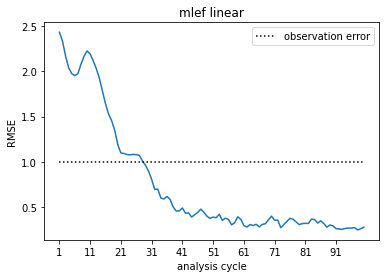

In [15]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()